# CSC 730 Assignment 1
## Mangesh Sakordekar, Jackson Cates

### Imports

In [68]:
from bidict import bidict
from datetime import datetime
import numpy as np
from scipy.spatial import distance
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn import datasets, metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [69]:
# %matplotlib qt

### Preprocessing Data

In [70]:
X_y = np.load('skewed_MNIST.npy')
X = X_y[:,:-1]
y = X_y[:,-1]
print(X.shape,y.shape)

(12244, 784) (12244,)


Text(0, 0.5, 'frequency')

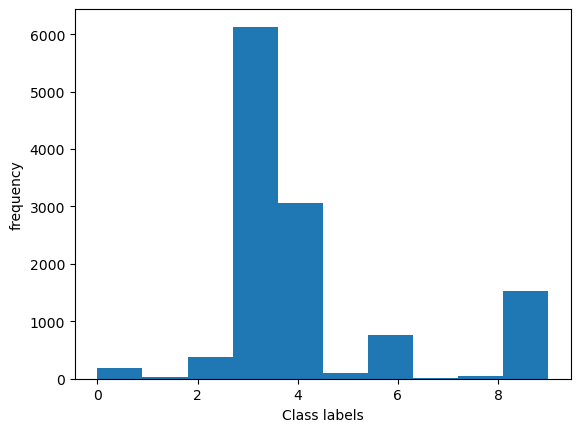

In [71]:
plt.hist(y)
plt.xlabel('Class labels')
plt.ylabel('frequency')

In [72]:
values, counts = np.unique(y, return_counts=True)
values, counts

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([ 191,   23,  383, 6131, 3065,   95,  766,   11,   47, 1532],
       dtype=int64))

In [73]:
counts / len(y)

array([0.01559948, 0.00187847, 0.03128063, 0.50073505, 0.25032669,
       0.0077589 , 0.06256125, 0.0008984 , 0.00383861, 0.12512251])

## PCA

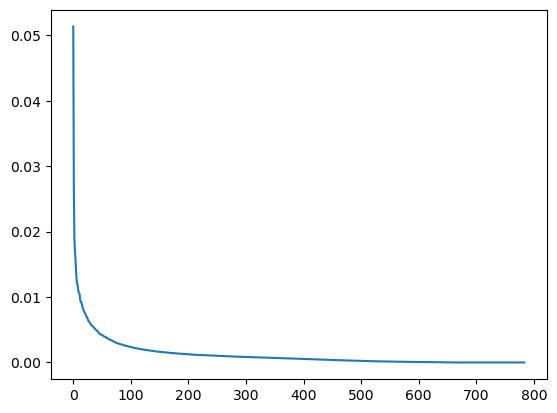

In [74]:
X_t = X.T
mean = np.mean(X_t, axis=0)
std_dev = np.std(X_t, axis=0)
X_t = (X_t - mean) / std_dev
U, S, V = np.linalg.svd(X_t)
sum = 0
importances = []
for s in S:
    importances.append(s / np.sum(S))
plt.plot(importances)

Text(0, 0.5, 'Explained Variance')

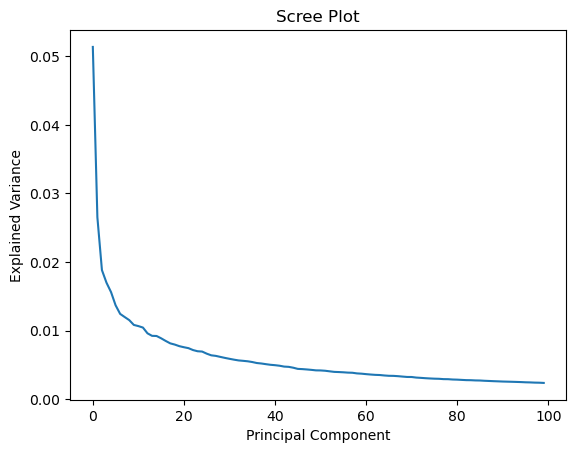

In [75]:
plt.plot(importances[:100])
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')

In [76]:
k = 5
U_k = U[:,:k]
X_hat = U_k @ U_k.T @ X_t
scores = np.linalg.norm(X_hat - X_t, axis=0)
scores.shape

(12244,)

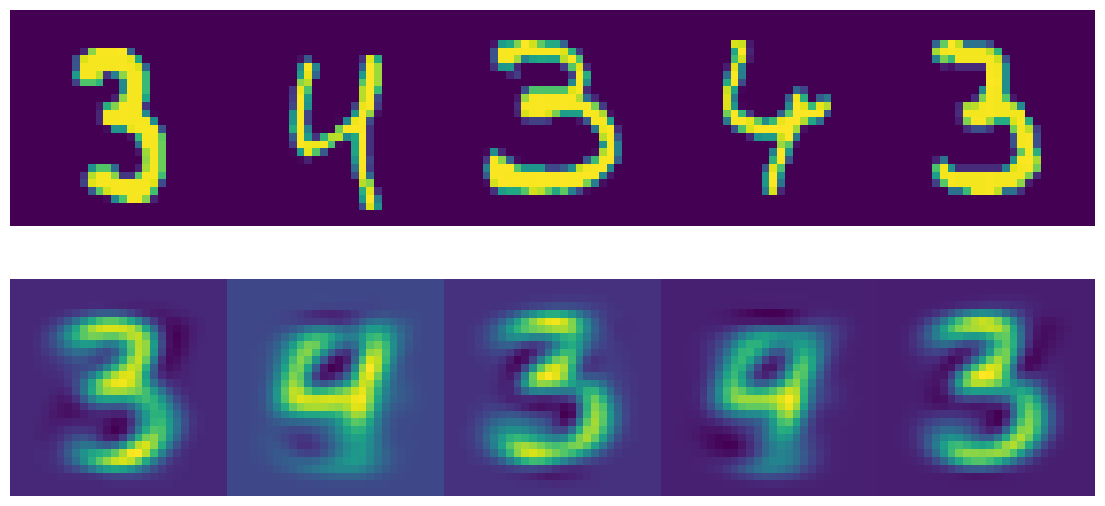

In [77]:
fig, axs = plt.subplots(2,5,figsize=(14,7))
for i in range(5):
    random_i = np.random.randint(0,len(y))
    x = X[random_i].reshape(28,28)
    x_hat = X_hat[:,random_i].reshape(28,28)
    axs[0,i].imshow(x)
    axs[1,i].imshow(x_hat)
for ax in axs.flatten():
    ax.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)

<BarContainer object of 12244 artists>

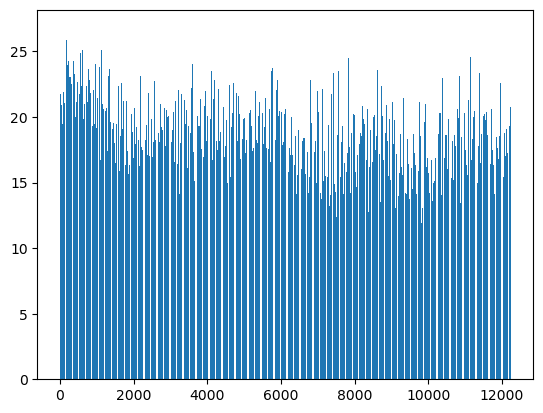

In [78]:
plt.bar(np.arange(len(scores)), scores)

In [79]:
i_order = np.argsort(scores)[::-1]
y_pred = [y[i] for i in i_order]

In [80]:
cm = confusion_matrix(y, y_pred)
cm

array([[  19,    7,   29,   38,   43,   10,   29,    1,    3,   12],
       [   8,    0,    2,    2,    1,    2,    4,    0,    0,    4],
       [  26,    1,   52,  114,   88,   11,   61,    1,    4,   25],
       [  17,    2,   10, 3945, 1183,    8,  166,    0,    6,  794],
       [  29,    1,   74, 1262, 1035,   22,  188,    1,   12,  441],
       [  11,    5,   25,   23,   12,    2,   11,    1,    1,    4],
       [  33,    4,   83,  249,  196,   18,  109,    4,    9,   61],
       [   4,    0,    0,    0,    1,    1,    3,    0,    0,    2],
       [  12,    0,   10,    7,    3,    2,   11,    0,    0,    2],
       [  32,    3,   98,  491,  503,   19,  184,    3,   12,  187]],
      dtype=int64)

In [81]:
cm.trace() / np.sum(cm)

0.4368670369160405

## Convolutional Autoencoders

In [82]:
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [83]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [84]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [85]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [86]:

mnist_digits = np.reshape(X, (12244,28,28))
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(mnist_digits, epochs=10, batch_size=128)

Epoch 1/10
96/96 [==============================] - 15s 158ms/step - total_loss: 289.7117 - reconstruction_loss: 287.1234 - kl_loss: 2.5891
Epoch 2/10
96/96 [==============================] - 15s 156ms/step - total_loss: 203.8428 - reconstruction_loss: 201.1050 - kl_loss: 2.7344
Epoch 3/10
96/96 [==============================] - 15s 155ms/step - total_loss: 182.3098 - reconstruction_loss: 178.1031 - kl_loss: 4.2081
Epoch 4/10
96/96 [==============================] - 15s 154ms/step - total_loss: 174.5306 - reconstruction_loss: 170.2998 - kl_loss: 4.2313
Epoch 5/10
96/96 [==============================] - 15s 155ms/step - total_loss: 169.6018 - reconstruction_loss: 165.6825 - kl_loss: 3.9199
Epoch 6/10
96/96 [==============================] - 15s 155ms/step - total_loss: 166.1962 - reconstruction_loss: 162.5148 - kl_loss: 3.6818
Epoch 7/10
96/96 [==============================] - 15s 157ms/step - total_loss: 163.5319 - reconstruction_loss: 159.9536 - kl_loss: 3.5792
Epoch 8/10
96/96 [==

In [87]:
encoded = vae.encoder.predict(mnist_digits)
x_decoded = vae.decoder.predict(encoded[0], verbose=0)

383/383 [==============================] - 1s 2ms/step


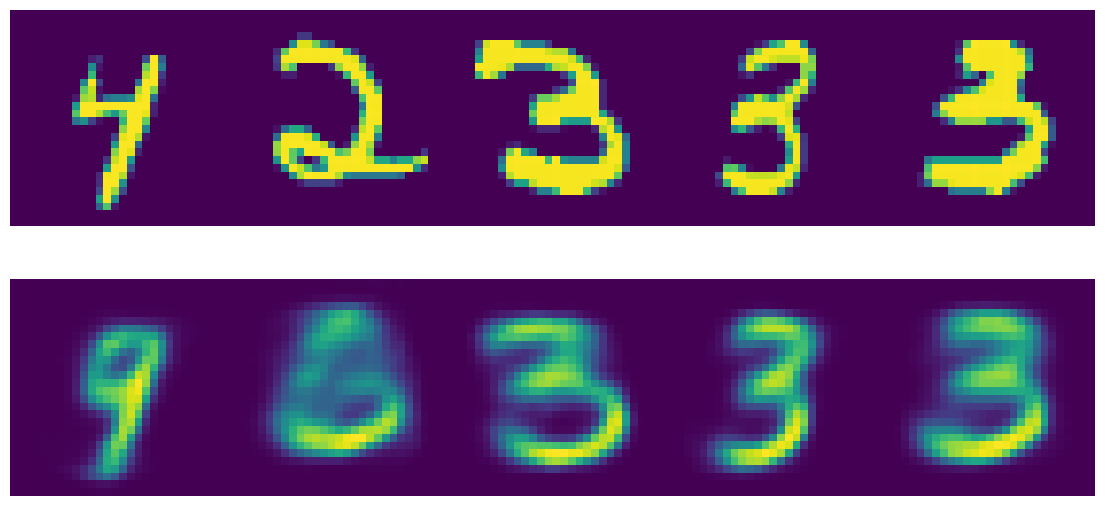

In [104]:
fig, axs = plt.subplots(2,5,figsize=(14,7))
for i in range(5):
    random_i = np.random.randint(0,len(y))
    x = X[random_i].reshape(28,28)
    x_hat = x_decoded[random_i].reshape(28,28)
    axs[0,i].imshow(x)
    axs[1,i].imshow(x_hat)
for ax in axs.flatten():
    ax.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)

In [89]:
original = np.reshape(mnist_digits, (12244, 784))
generated = np.reshape(x_decoded, (12244, 784))

In [90]:
cae_scores = np.sum(abs(original - generated), axis = 1)
dec_ind = np.argsort(cae_scores)[::-1]
dec_order = y[dec_ind]

<BarContainer object of 12244 artists>

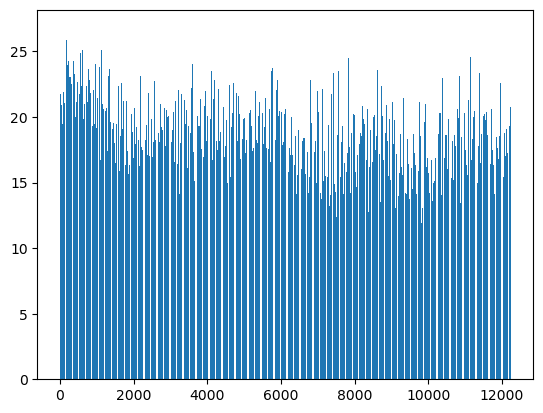

In [91]:
plt.bar(np.arange(len(cae_scores)), scores)

In [92]:
cae_cm = confusion_matrix(y,dec_order)
cae_cm

array([[  34,    0,   53,   54,   12,    1,   14,    2,    2,   19],
       [   9,    0,    6,    4,    1,    1,    0,    0,    1,    1],
       [  44,    0,   96,  147,   32,    8,   36,    0,    1,   19],
       [   0,   13,    3, 3064, 1840,   10,   35,    4,    7, 1155],
       [   4,    8,   22, 1679,  775,   26,  319,    2,   22,  208],
       [  24,    0,   35,   21,    5,    3,    2,    0,    0,    5],
       [  30,    0,  101,  352,  117,   21,   98,    1,    4,   42],
       [   3,    0,    2,    2,    0,    0,    2,    0,    0,    2],
       [  18,    0,    9,   10,    2,    1,    3,    0,    1,    3],
       [  25,    2,   56,  798,  281,   24,  257,    2,    9,   78]],
      dtype=int64)

In [93]:
cae_cm.trace()/12244

0.338859849722313

## Binary Classification

[0. 1. 2. 5. 7. 8.]
PCA AUC = 0.853464764224813
Autoencoder AUC = 0.8950562032364712


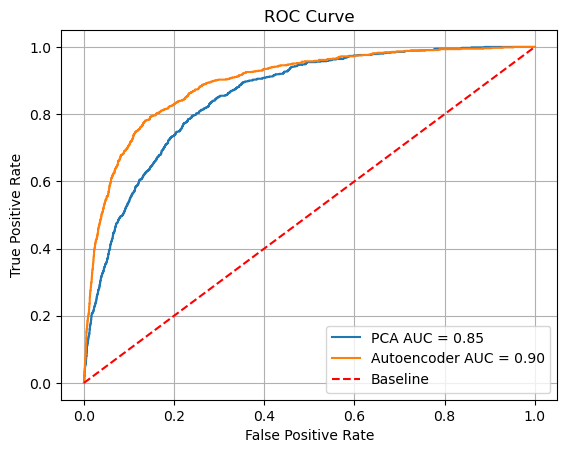

In [99]:
from sklearn.metrics import roc_curve, roc_auc_score

binary = np.zeros(len(y))
anomal_classes = values[counts / len(y) < 0.05]
print(anomal_classes)
binary[[s in anomal_classes for s in y]] = 1
fpr, tpr, thresholds = roc_curve(binary, scores)
cae_fpr, cae_tpr, cae_thresholds = roc_curve(binary, cae_scores)
auc = roc_auc_score(binary, scores)
cae_auc = roc_auc_score(binary, cae_scores)
print("PCA AUC =", auc)
print("Autoencoder AUC =", cae_auc)
plt.plot(fpr, tpr, label=f'PCA AUC = {auc:.2f}')
plt.plot(cae_fpr, cae_tpr, label=f'Autoencoder AUC = {cae_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Baseline')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

In [95]:
best_idx = np.argmax(tpr - fpr)
best_threshold = thresholds[best_idx]
binary_pred = np.zeros(len(y))
binary_pred[scores > best_threshold] = 1
cm2 = confusion_matrix(binary, binary_pred)
cm2

array([[8723, 2771],
       [ 154,  596]], dtype=int64)

In [96]:
cm2.trace() / len(y)

0.7611074812152892

In [97]:
best_idx = np.argmax(cae_tpr - cae_fpr)
best_threshold = cae_thresholds[best_idx]
binary_pred = np.zeros(len(y))
binary_pred[cae_scores > best_threshold] = 1
cae_cm2 = confusion_matrix(binary, binary_pred)
cae_cm2

array([[9929, 1565],
       [ 165,  585]], dtype=int64)

In [98]:
cae_cm2.trace() / len(y)

0.8587063051290428